# NBA Assist Networks

Similar to tutorial about [WNBA Assist Networks](https://github.com/basketballrelativity/assist_networks/blob/master/wnba_assist_networks.ipynb), this tutorial dives into the NBA side and demonstrates how to build assist networks using data from [stats.nba.com](https://stats.nba.com).

The following explores the `PlayByPlay` and `Player` classes of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `playbyplayv2` and `shotchartdetail` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to follow the same methodology as used on the WNBA side to generate assist networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import playbyplay, player

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `PlayByPlay` class requires just one parameter:
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 NBA Finals game between the Raptors and the Warriors.

In [2]:
game_id = '0021900115'
plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

play_df = pd.DataFrame(plays.data['PlayByPlay'])
play_df.head(35)

KeyboardInterrupt: 

By examining the above play, which includes an assisted basket, we see that the player credited with the assist is included in the play-by-play data through the PLAYER2 fields. We need to join this table to shot location data using the EVENTNUM field.

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:

- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)
- season_type: One of 'Regular Season', 'Pre Season', 'Playoffs', 'All Star'

In [ ]:
play_df.loc[2]['PLAYER1_TEAM_ID']

In [8]:
league_id = '00' #NBA
player_id = '0' #All players
season = '2019-20'
season_type = 'Regular Season'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season,
                      season_type=season_type)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900002,7,2544,LeBron James,1610612747,Los Angeles Lakers,1,11,47,...,Center(C),Less Than 8 ft.,2,-9,23,1,1,20191022,LAC,LAL
1,Shot Chart Detail,0021900002,9,1629013,Landry Shamet,1610612746,LA Clippers,1,11,40,...,Right Side Center(RC),24+ ft.,26,201,178,1,0,20191022,LAC,LAL
2,Shot Chart Detail,0021900002,11,201980,Danny Green,1610612747,Los Angeles Lakers,1,11,23,...,Right Side Center(RC),24+ ft.,25,125,221,1,1,20191022,LAC,LAL
3,Shot Chart Detail,0021900002,13,201976,Patrick Beverley,1610612746,LA Clippers,1,11,0,...,Right Side Center(RC),24+ ft.,26,117,239,1,0,20191022,LAC,LAL
4,Shot Chart Detail,0021900002,15,203076,Anthony Davis,1610612747,Los Angeles Lakers,1,10,47,...,Right Side Center(RC),16-24 ft.,18,96,162,1,0,20191022,LAC,LAL
5,Shot Chart Detail,0021900002,18,202695,Kawhi Leonard,1610612746,LA Clippers,1,10,29,...,Right Side(R),8-16 ft.,14,110,90,1,0,20191022,LAC,LAL
6,Shot Chart Detail,0021900002,20,1627826,Ivica Zubac,1610612746,LA Clippers,1,10,24,...,Center(C),Less Than 8 ft.,0,0,-6,1,1,20191022,LAC,LAL
7,Shot Chart Detail,0021900002,21,2544,LeBron James,1610612747,Los Angeles Lakers,1,10,5,...,Left Side(L),8-16 ft.,14,-144,41,1,1,20191022,LAC,LAL
8,Shot Chart Detail,0021900002,24,201980,Danny Green,1610612747,Los Angeles Lakers,1,9,52,...,Left Side(L),24+ ft.,23,-234,12,1,0,20191022,LAC,LAL
9,Shot Chart Detail,0021900002,27,201580,JaVale McGee,1610612747,Los Angeles Lakers,1,9,30,...,Center(C),Less Than 8 ft.,0,-1,7,1,1,20191022,LAC,LAL


In [9]:
assist_df = shot_df.merge(play_df[['EVENTNUM',
                                   'HOMEDESCRIPTION',
                                   'VISITORDESCRIPTION',
                                   'PLAYER2_ID',
                                   'PLAYER2_NAME']], left_on='GAME_EVENT_ID', right_on='EVENTNUM')

assist_df = assist_df[pd.notnull(assist_df['PLAYER2_NAME'])]

In [10]:
assist_df.head().T

,0,2,9,14,15
GRID_TYPE,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail
GAME_ID,0021900002,0021900002,0021900002,0021900002,0021900002
GAME_EVENT_ID,7,11,27,54,57
PLAYER_ID,2544,201980,201580,1626149,1626149
PLAYER_NAME,LeBron James,Danny Green,JaVale McGee,Montrezl Harrell,Montrezl Harrell
TEAM_ID,1610612747,1610612747,1610612747,1610612746,1610612746
TEAM_NAME,Los Angeles Lakers,Los Angeles Lakers,Los Angeles Lakers,LA Clippers,LA Clippers
PERIOD,1,1,1,1,1
MINUTES_REMAINING,11,11,9,7,7
SECONDS_REMAINING,47,23,30,55,18


To create a network, we need to establish both nodes and edges. Each edge goes from a source node (assisting player) to a target node. The `network_data` function below also establishes coordinates for each node, along with the number of assists for each player. 

In [11]:
def network_data(pbp_df, team_id):
    """ network_dict creates nodes and edges
    for an assist network, along with information
    needed to plot the network

    @param pbp_df (DataFrame): DataFrame of play-by-play
        data with timeouts removed. Timeouts cause complications
        with getting players from the 'epid' field

    @param team_id (int): Unique team identifier

    Returns

        unique_players (list): List of player ID numbers
            corresponding to players on the team given

        edges (list): List of tuples in the form
            (assisting player ID, scoring player ID, number of assists)

        pos_dict (dict): Dictionary with keys of player ID numbers
            with (x, y) values corresponding to node coordinates

        weights (dict): Dictionary with keys of player ID numbers
            with assists as values
    """

    # First, let's identify all players on the team provided
    network = {}
    assist_df = pbp_df[pbp_df['TEAM_ID'] == team_id]
    unique_players = list(set(list(assist_df['PLAYER_ID']) + list(assist_df['PLAYER2_ID'])))
    unique_players = list(set([int(x) for x in unique_players]))

    # Next, we'll isolate the assists and loop through all unique assist
    # partners (assisting player, scorer)
    network['links'] = {}
    count = 0
    all_assists = zip(assist_df['PLAYER2_ID'], assist_df['PLAYER_ID'])
    all_assists = [(int(x), int(y)) for x, y in all_assists]
    unique_assists = list(set(all_assists))
    weights = {}
    for source, target in unique_assists:
        network['links'][count] = {}
        network['links'][count]['source'] = source
        network['links'][count]['target'] = target
        network['links'][count]['weight'] = sum([1 if x == (source, target) else 0 for x in all_assists])
        weights[(source, target)] = network['links'][count]['weight']
        count += 1

    links = len(network['links'])
    edges = [(network['links'][k]['source'],
              network['links'][k]['target'],
              network['links'][k]['weight']) for k in range(links)]

    # Finally, we'll get coordinates for all players in the assist
    # network around the unit circle
    angles = np.linspace(0, 360 - 360/float(len(unique_players)), len(unique_players))
    pos_dict = {}
    for angle, player in zip(angles, unique_players):
        pos_dict[player] = (np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle)))

    return unique_players, edges, pos_dict, weights

In [22]:
team_id = 1610612747
nodes, edges, positions, weights = network_data(assist_df, team_id)

Finally, we can write a function that uses `matplotlib` to visualize the assist network given the components created above. Let's first create a dictionary of names for display purposes.

In [23]:
team_df = assist_df[assist_df['TEAM_ID']==team_id]
team_name = team_df['TEAM_NAME'].iloc[0]
players = {}
unique_scorers = list(set(team_df['PLAYER_ID']))
for player in unique_scorers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER_ID']==player]['PLAYER_NAME'].iloc[0]

unique_passers = list(set(team_df['PLAYER2_ID']))
for player in unique_passers:
    if player not in players:
        players[player] = team_df[team_df['PLAYER2_ID']==player]['PLAYER2_NAME'].iloc[0]

In [24]:
def plot_network(nodes, edges, positions, weights, players, team):
    """ plot_network plots the assist network given the
    data from the network_data function.

    @param nodes (list): List of player ID numbers
        corresponding to players on the team given

    @param edges (list): List of tuples in the form
        (assisting player ID, scoring player ID, number of assists)

    @param positions (dict): Dictionary with keys of player ID numbers
         with (x, y) values corresponding to node coordinates

    @param weights (dict): Dictionary with keys of player ID numbers
        with assists as values

    @param players (dict): Dict keyed by player IDs with their names
        as values

    @param team (str): Team name

    Returns

        fig (maplotlib.figure.Figure): Assist network visual
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')
    plt.title(team + ' Assist Network', fontsize=18)

    # First, let's plot each node, labeling each with player name and
    # number of assists. The number of assists also control the markersize
    # of the nodes. Because of this and varying name lengths, the name
    # position is perturbed to ensure proper formatting
    for pos in positions:
        assists = sum([weights[x] if x[0] == pos else 0 for x in weights])
        plt.plot(positions[pos][0], positions[pos][1], marker='o',
                 markersize=(1 + assists)*5, markeredgecolor='k', fillstyle='none')
        name = players[pos] + ' (' + str(int(assists)) + ')'
        if positions[pos][1] == 1:
            vertical_perturb = 0.003*(1 + assists)*5
        elif positions[pos][1] == -1:
            vertical_perturb = -0.005*(1 + assists)*5 - 0.05
        else:
            vertical_perturb = 0

        if positions[pos][0] < 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = -0.0325*len(name) - 0.0025*(1 + assists)*5
        elif positions[pos][0] >= 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = 0.0025*len(name) + 0.0025*(1 + assists)*5
        else:
            horiz_perturb = -0.0175*len(name)
            
        plt.text(positions[pos][0] + horiz_perturb, positions[pos][1] + vertical_perturb,
                 name, fontsize=12)

    # Next, the edges are plotted as arrows with the arrow going from 
    # the assisting player to the scoring player. The size of the arrow
    # is a function of the number of assists for that directed pair.
    # Also, the transparency is set to 0.5 to account for instances
    # when a pair of players have assists to each other.
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        assists = edge[2]

        start_x = positions[node1][0]
        start_y = positions[node1][1]

        delta_x = positions[node2][0] - start_x
        delta_y = positions[node2][1] - start_y

        plt.arrow(start_x, start_y, delta_x, delta_y, width=0.015*assists,
                  length_includes_head=True, alpha=0.5)

    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    axis.set_aspect(1.0)
    plt.axis('off')
    plt.close()

    return fig

In [25]:
network = plot_network(nodes, edges, positions, weights, players, team_name)

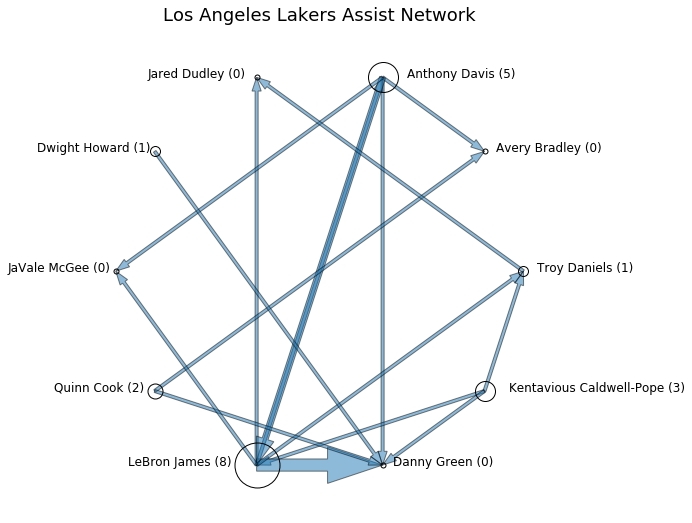

In [26]:
network

The assist network communicates a lot of information in a compact form:
    - Kyle Lowry led the team with nine assists and distributed them to six different teammates
    - Patrick McCaw had an assist but did not score an assisted basket
    - Danny Green was the beneficiary of six assists
    - The greatest number of assists from one player to another is four
    
## Exploration

    - What else can you add or change about the above assist network to enhance the visualization?
    - What other events in basketball could be visualized by a network?